In [111]:
# Import required libraries and dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [112]:
# Load the data into a Pandas DataFrame
df_market_data = pd.read_csv(
    "Resources/crypto_market_data.csv",
    index_col="coin_id")

# Display sample data
df_market_data.head(10)

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
coin_id,,,,,,,
bitcoin,1.08388,7.60278,6.57509,7.67258,-3.25185,83.51840,37.51761
ethereum,0.22392,10.38134,4.80849,0.13169,-12.88890,186.77418,101.96023
tether,-0.21173,0.04935,0.00640,-0.04237,0.28037,-0.00542,0.01954
ripple,-0.37819,-0.60926,2.24984,0.23455,-17.55245,39.53888,-16.60193
bitcoin-cash,2.90585,17.09717,14.75334,15.74903,-13.71793,21.66042,14.49384
binancecoin,2.10423,12.85511,6.80688,0.05865,36.33486,155.61937,69.69195
chainlink,-0.23935,20.69459,9.30098,-11.21747,-43.69522,403.22917,325.13186
cardano,0.00322,13.99302,5.55476,10.10553,-22.84776,264.51418,156.09756
litecoin,-0.06341,6.60221,7.28931,1.21662,-17.23960,27.49919,-12.66408


In [113]:
# Generate summary statistics
df_market_data.describe()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,-0.269686,4.497147,0.185787,1.545693,-0.094119,236.537432,347.667956
std,2.694793,6.375218,8.376939,26.344218,47.365803,435.225304,1247.842884
min,-13.527860,-6.094560,-18.158900,-34.705480,-44.822480,-0.392100,-17.567530
25%,-0.608970,0.047260,-5.026620,-10.438470,-25.907990,21.660420,0.406170
50%,-0.063410,3.296410,0.109740,-0.042370,-7.544550,83.905200,69.691950
75%,0.612090,7.602780,5.510740,4.578130,0.657260,216.177610,168.372510
max,4.840330,20.694590,24.239190,140.795700,223.064370,2227.927820,7852.089700


In [114]:
# Plot your data to see what's in your DataFrame
df_market_data.hvplot.line(
    width=800,
    height=400,
    rot=90
)

:NdOverlay   [Variable]
   :Curve   [coin_id]   (value)

---

### Prepare the Data

In [115]:
# 1. Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
scaler = StandardScaler()

# 2. Specify the features to scale
features = ["price_change_percentage_24h", "price_change_percentage_7d"]
X = df_market_data[features].copy()

# 3. Fit the scaler and transform the data
X_scaled = scaler.fit_transform(X)

In [116]:
# 4. Copy the crypto names (coin_id) from the original DataFrame
crypto_names = df_market_data.index

# 5. Create a DataFrame with the scaled data using `crypto_names` as the index
scaled_df = pd.DataFrame(X_scaled, columns=features, index=crypto_names)

# 6. (Optional) Keep coin_id as a column for later reference (e.g. in hvPlot tooltips)
scaled_df["coin_id"] = scaled_df.index

# 7. Display the scaled DataFrame
scaled_df.head()

,price_change_percentage_24h,price_change_percentage_7d,coin_id
coin_id,,,
bitcoin,0.508529,0.493193,bitcoin
ethereum,0.185446,0.934445,ethereum
tether,0.021774,-0.706337,tether
ripple,-0.040764,-0.810928,ripple
bitcoin-cash,1.193036,2.000959,bitcoin-cash


---

### Find the Best Value for k Using the Original Scaled DataFrame.

In [117]:
# Create a list with the number of k-values from 1 to 11
k_values = range(1, 11)
scaled_df_numeric = scaled_df.drop(["coin_id", "cluster"], axis=1, errors="ignore")

In [118]:
# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df_numeric)
    inertia.append(kmeans.inertia_)
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
elbow_data = {
    "k": k_values,
    "inertia": inertia
}
elbow_df = pd.DataFrame(elbow_data)
# 2. Fit the model to the data using `df_market_data_scaled`
# 3. Append the model.inertia_ to the inertia list
elbow_df

c:\Users\jdimi\anaconda3\envs\dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jdimi\anaconda3\envs\dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jdimi\anaconda3\envs\dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jdimi\anaconda3\envs\dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is k

,k,inertia
0,1,82.000000
1,2,55.059288
2,3,44.076901
3,4,20.952553
4,5,15.073548
5,6,13.288119
6,7,11.828786
7,8,8.553593
8,9,7.336141
9,10,6.277035


In [119]:
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {
    "k": k_values,
    "inertia": inertia
}

# Create a DataFrame with the data to plot the Elbow curve
elbow_df = pd.DataFrame(elbow_data)

# Check
elbow_df

,k,inertia
0,1,82.000000
1,2,55.059288
2,3,44.076901
3,4,20.952553
4,5,15.073548
5,6,13.288119
6,7,11.828786
7,8,8.553593
8,9,7.336141
9,10,6.277035


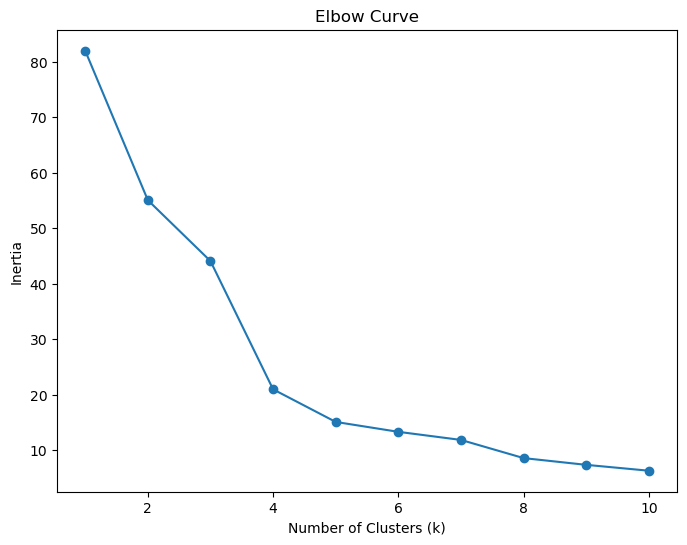

In [120]:
# Plot a line chart with all the inertia values computed with
# the different values of k to visually identify the optimal value for k.
plt.figure(figsize=(8,6))
plt.plot(elbow_df["k"], elbow_df["inertia"], marker="o")
plt.title("Elbow Curve")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

#### Answer the following question: 

**Question:** What is the best value for `k`?

**Answer:** The best value for `k' would be 4. The largest drop or bend can be seen between 3 and 4. With 4 being the point of inflection.

---

### Cluster Cryptocurrencies with K-means Using the Original Scaled DataFrame

In [121]:
# Initialize the K-Means model using the best value for k
k_value = 4
model = KMeans(n_clusters=k_value, random_state=42)

In [122]:
# Select only numeric columns
scaled_df_numeric = scaled_df.select_dtypes(include=[np.number]).copy()

# Fit the model on numeric columns only
model.fit(scaled_df_numeric)

c:\Users\jdimi\anaconda3\envs\dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [123]:
# Predict the clusters to group the cryptocurrencies using the scaled DataFrame
cluster_labels = model.predict(scaled_df_numeric)


# Print the resulting array of cluster values.
print("Cluster labels:", cluster_labels)

Cluster labels: [0 0 1 1 2 2 2 2 0 1 1 1 1 2 0 0 1 1 2 1 1 0 1 1 1 1 0 1 0 1 0 1 3 0 0 2 1
 1 0 1 1]


In [124]:
# Create a copy of the scaled DataFrame
clustered_scaled_df = scaled_df.copy()

In [125]:
# Add a new column to the copy of the scaled DataFrame with the predicted clusters
clustered_scaled_df["cluster"] = cluster_labels

# Display the copy of the scaled DataFrame
clustered_scaled_df.head()

,price_change_percentage_24h,price_change_percentage_7d,coin_id,cluster
coin_id,,,,
bitcoin,0.508529,0.493193,bitcoin,0
ethereum,0.185446,0.934445,ethereum,0
tether,0.021774,-0.706337,tether,1
ripple,-0.040764,-0.810928,ripple,1
bitcoin-cash,1.193036,2.000959,bitcoin-cash,2


In [126]:
# Create a scatter plot using hvPlot by setting
# `x="price_change_percentage_24h"` and `y="price_change_percentage_7d"`.
# Color the graph points with the labels found using K-Means and
# add the crypto name in the `hover_cols` parameter to identify
# the cryptocurrency represented by each data point.
clustered_scaled_df.hvplot.scatter(
    x="price_change_percentage_24h",
    y="price_change_percentage_7d",
    by="cluster",             # Colors the points by the cluster labels
    hover_cols=["coin_id"],   # Shows the crypto name/id when hovering
    title="Cryptocurrencies Clusters (Scaled Data)",
    width=700,
    height=500
)

:NdOverlay   [cluster]
   :Scatter   [price_change_percentage_24h]   (price_change_percentage_7d,coin_id)

---

### Optimize Clusters with Principal Component Analysis.

In [127]:
# Create a PCA model instance and set `n_components=3`.
pca = PCA(n_components=2)

In [128]:
# Use the PCA model with `fit_transform` to reduce the original scaled DataFrame
# down to three principal components.
pca_data = pca.fit_transform(scaled_df_numeric)

# View the scaled PCA data
pca_columns = ["PC1", "PC2"]
pca_df = pd.DataFrame(
    data=pca_data,
    columns=pca_columns,
    index=scaled_df_numeric.index
)
display(pca_df.head())

,PC1,PC2
coin_id,,
bitcoin,-0.708325,-0.010844
ethereum,-0.791882,0.529622
tether,0.484059,-0.514852
ripple,0.602238,-0.544588
bitcoin-cash,-2.258496,0.571288


In [129]:
# Retrieve the explained variance to determine how much information
# can be attributed to each principal component.
explained_variance = pca.explained_variance_ratio_

print("Explained Variance Ratio per Component:", explained_variance)
print("Total Explained Variance:", explained_variance.sum())

Explained Variance Ratio per Component: [0.58482974 0.41517026]
Total Explained Variance: 1.0


#### Answer the following question: 

**Question:** What is the total explained variance of the three principal components?

**Answer:** 100% of the variance in the original data is captured by these two components

In [130]:
# Create a new DataFrame with the PCA data.
pca_df = pd.DataFrame(
    data=pca_data,
    columns=pca_columns,
    index=scaled_df.index  
)

# Copy the crypto names from the original scaled DataFrame
# Set the coin_id column as index
pca_df["coin_id"] = pca_df.index

# Display the scaled PCA DataFrame
pca_df.head()

,PC1,PC2,coin_id
coin_id,,,
bitcoin,-0.708325,-0.010844,bitcoin
ethereum,-0.791882,0.529622,ethereum
tether,0.484059,-0.514852,tether
ripple,0.602238,-0.544588,ripple
bitcoin-cash,-2.258496,0.571288,bitcoin-cash


---

### Find the Best Value for k Using the Scaled PCA DataFrame

In [131]:
# Create a list with the number of k-values from 1 to 11
k_values = range(1, 12)

In [132]:
# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
for k in k_values:
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
 kmeans_pca = KMeans(n_clusters=k, random_state=42)
# 2. Fit the model to the data using `df_market_data_pca`
 kmeans_pca.fit(pca_df.drop(["coin_id"], axis=1))
# 3. Append the model.inertia_ to the inertia list
 inertia.append(kmeans_pca.inertia_)

c:\Users\jdimi\anaconda3\envs\dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jdimi\anaconda3\envs\dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jdimi\anaconda3\envs\dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jdimi\anaconda3\envs\dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is k

In [133]:
print("Length of k_values:", len(k_values))
print("Length of inertia:", len(inertia))


Length of k_values: 11
Length of inertia: 11


In [134]:
# Create a dictionary with the data to plot the Elbow curve
elbowPCA_data = {
    "k": k_values,
    "inertia": inertia
}
# Create a DataFrame with the data to plot the Elbow curve
elbowPCA_df = pd.DataFrame(elbowPCA_data)

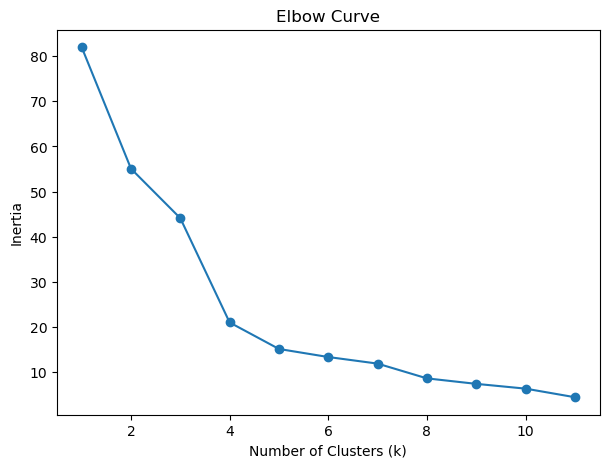

In [135]:
# Plot a line chart with all the inertia values computed with
# the different values of k to visually identify the optimal value for k.
plt.figure(figsize=(7,5))
plt.plot(elbowPCA_df["k"], elbowPCA_df["inertia"], marker="o")
plt.title("Elbow Curve")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

#### Answer the following questions: 

* **Question:** What is the best value for `k` when using the PCA data?

  * **Answer:**
From the elbow curve, the inertia shows its largest drop-off around 4. After 4, the slope flattens significantly, indicating that 4 is a good choice for the number of clusters.

* **Question:** Does it differ from the best k value found using the original data?

  * **Answer:** 
  In this example, the optimal k remains 4, so it does not differ from the best k found with the original scaled data.

### Cluster Cryptocurrencies with K-means Using the Scaled PCA DataFrame

In [136]:
# Initialize the K-Means model using the best value for k
best_k = 4
kmeans_pca = KMeans(n_clusters=best_k, random_state=42)

In [137]:
# Fit the K-Means model using the PCA data
kmeans_pca.fit(pca_df.drop(["coin_id"], axis=1, errors="ignore"))

c:\Users\jdimi\anaconda3\envs\dev\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [138]:
# Predict the clusters to group the cryptocurrencies using the scaled PCA DataFrame
pca_cluster_labels = kmeans_pca.predict(pca_df.drop(["coin_id"], axis=1, errors="ignore"))

# Print the resulting array of cluster values.
print("Cluster labels:", pca_cluster_labels)

Cluster labels: [0 0 1 1 2 2 2 2 0 1 1 1 1 2 0 0 1 1 2 1 1 0 1 1 1 1 0 1 0 1 0 1 3 0 0 2 1
 1 0 1 1]


In [139]:
# Create a copy of the scaled PCA DataFrame
clustered_pca_df = pca_df.copy()

# Add a new column to the copy of the PCA DataFrame with the predicted clusters
clustered_pca_df["cluster"] = pca_cluster_labels

# Display the copy of the scaled PCA DataFrame
clustered_pca_df.head()

,PC1,PC2,coin_id,cluster
coin_id,,,,
bitcoin,-0.708325,-0.010844,bitcoin,0
ethereum,-0.791882,0.529622,ethereum,0
tether,0.484059,-0.514852,tether,1
ripple,0.602238,-0.544588,ripple,1
bitcoin-cash,-2.258496,0.571288,bitcoin-cash,2


In [140]:
# Create a scatter plot using hvPlot by setting
# `x="PC1"` and `y="PC2"`.
# Color the graph points with the labels found using K-Means and
# add the crypto name in the `hover_cols` parameter to identify
# the cryptocurrency represented by each data point.

clustered_pca_df.hvplot.scatter(
    x="PC1",
    y="PC2",             
    by="cluster", 
    hover_cols=["coin_id"],
    title="Cryptocurrency Clusters (PCA Data)",
    width=800,
    height=500
)

:NdOverlay   [cluster]
   :Scatter   [PC1]   (PC2,coin_id)

### Visualize and Compare the Results

In this section, you will visually analyze the cluster analysis results by contrasting the outcome with and without using the optimization techniques.

In [141]:
# Composite plot to contrast the Elbow curves
# YOUR CODE HERE!
# Elbow curve for original data
elbow_original_plot = elbow_df.hvplot.line(
    x="k", y="inertia",
    title="Elbow Curve Comparison",
    xlabel="Number of Clusters (k)",
    ylabel="Inertia",
    label="Original Data",
    width=800, height=400
)

# Elbow curve for PCA data (ensure this DataFrame exists and is named correctly)
elbow_pca_plot = elbowPCA_df.hvplot.line(
    x="k", y="inertia",
    xlabel="Number of Clusters (k)",
    ylabel="Inertia",
    label="PCA Data"
)

# Combine the plots into a single composite plot
elbow_comparison_plot = elbow_original_plot * elbow_pca_plot
elbow_comparison_plot


:Overlay
   .Curve.Original_Data :Curve   [k]   (inertia)
   .Curve.PCA_Data      :Curve   [k]   (inertia)

In [142]:
# Composite plot to contrast the clusters
# YOUR CODE HERE!

# Scatter plot for clusters using original scaled data
original_cluster_plot = clustered_scaled_df.hvplot.scatter(
    x="price_change_percentage_24h",
    y="price_change_percentage_7d",
    by="cluster",
    hover_cols=["coin_id"],
    title="Clusters (Combined Data)",
    width=700,
    height=500
)

# Scatter plot for clusters using PCA data
pca_cluster_plot = clustered_pca_df.hvplot.scatter(
    x="PC1",
    y="PC2",
    by="cluster",
    hover_cols=["clusters"]
)

# Combine the two plots into a composite
cluster_comparison_plot = original_cluster_plot * pca_cluster_plot
cluster_comparison_plot

:Overlay
   .NdOverlay.I  :NdOverlay   [cluster]
      :Scatter   [price_change_percentage_24h]   (price_change_percentage_7d,coin_id)
   .NdOverlay.II :NdOverlay   [cluster]
      :Scatter   [PC1]   (PC2)

#### Answer the following question: 

  * **Question:** After visually analyzing the cluster analysis results, what is the impact of using fewer features to cluster the data using K-Means?

  * **Answer:** Using fewer features via PCA simplifies clustering and visualization while maintaining the overall structure of the data. The impact on cluster quality is minimal for this dataset, making PCA a valuable preprocessing step.